# [SF-DST] Credit scoring
## В этом соревновании предстоит предсказать вероятность дефолта заемщика

# Импорт библиотек

In [1]:
from pandas import Series 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore") 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Описание функций

In [3]:
# Функция для визуализации confusion_matrix
def show_confusion_matrix(y_true, y_pred):
    color_text = plt.get_cmap('PuBu')(0.95)
    class_names = ['Default', 'Non-Default']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Confusion Matrix")
    ax.title.set_fontsize(15)
    sns.heatmap(df, square=True, annot=True, fmt="d", linewidths=1, cmap="PuBu")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=14, color = color_text)
    ax.set_xlabel('Real Values', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()

In [4]:
# Функция для вывода метрик для оценки качества модели
def all_metrics(y_true, y_pred, y_pred_prob):
    dict_metric = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    
    dict_metric['Positive, P'] = [P,'default']
    dict_metric['Negative, N'] = [N,'non-default']
    dict_metric['True Positive, TP'] = [TP,'correctly identified default']
    dict_metric['True Negative, TN'] = [TN,'correctly identified non-default']
    dict_metric['False Positive, FP'] = [FP,'incorrectly identified default']
    dict_metric['False Negative, FN'] = [FN,'incorrectly identified non-default']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(P+N)']
    dict_metric['Precision'] = [precision_score(y_true, y_pred),'Precision = TP/(TP+FP)'] 
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'Recall = TP/P']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Harmonical mean of Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob),'ROC AUC Score']    

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Value', 'Description'])
    display(temp_df) 

# Загрузка данных

In [5]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

In [6]:
# Посмотрим на случайные 5 строк обучающей базы
train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
38328,66591,15MAR2014,GRD,M,29,N,N,0,0,-2.060934,4,60,1,3,50000,1,2,N,0
13932,11377,18JAN2014,GRD,M,52,Y,N,0,0,-0.797521,0,70,1,3,70000,1,4,Y,0
59668,56852,05MAR2014,SCH,F,40,N,N,0,0,-2.216977,1,60,2,3,15000,3,2,N,0
34657,13495,21JAN2014,SCH,F,39,N,N,0,0,-1.557471,1,50,1,2,24000,1,4,N,1
2103,51105,27FEB2014,UGR,M,26,Y,N,0,1,-1.512094,1,50,2,3,30000,1,1,N,1


In [7]:
# Посмотрим на случайные 5 строк тестовой базы
test.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
15484,49451,26FEB2014,GRD,F,28,Y,Y,0,1,-1.606393,32,70,2,3,320000,1,3,Y
3939,84208,01APR2014,UGR,F,31,N,N,1,0,-0.967209,4,60,2,3,40000,2,4,N
7080,65873,14MAR2014,SCH,F,54,Y,N,0,0,-1.315291,3,80,2,3,16000,1,3,Y
31110,17052,24JAN2014,SCH,F,34,N,N,0,0,-1.988373,2,80,2,3,50000,1,3,N
6247,22730,29JAN2014,GRD,M,30,N,N,0,0,-1.166273,1,40,1,3,40000,1,3,Y


Подробнее по признакам:
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

In [8]:
# Посмотрим на первые 10 строк sample_submission
sample_submission.head(10)

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
5,175,0.311599
6,57558,0.584807
7,88407,0.815792
8,79183,0.325037
9,69300,0.094011


In [9]:
# Информация об обучающей базе
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [10]:
# Информация о тестовой базе
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [11]:
# Статистическая информация об обучающей базе
train.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


In [12]:
# Статистическая информация о тестовой базе
test.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time
count,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000
mean,54945.647473,39.186002,0.268040,0.166772,-1.904152,2.014471,56.802938,1.573798,2.501087,40835.755729,1.728053,2.765798
std,31706.052195,11.513258,0.788478,0.372777,0.501764,2.296789,13.086646,0.527428,0.683227,43802.180951,1.120686,1.011560
min,4.000000,21.000000,0.000000,0.000000,-3.574197,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000
25%,27744.000000,30.000000,0.000000,0.000000,-2.261909,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000
50%,54657.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000
75%,82322.000000,48.000000,0.000000,0.000000,-1.563957,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000
max,110148.000000,71.000000,30.000000,1.000000,0.188820,47.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000


# Предобработка данных

In [13]:
# Посмотрим на рапределение целевой переменной
train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

In [14]:
# Количество пропусков в обучающей базе
train.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

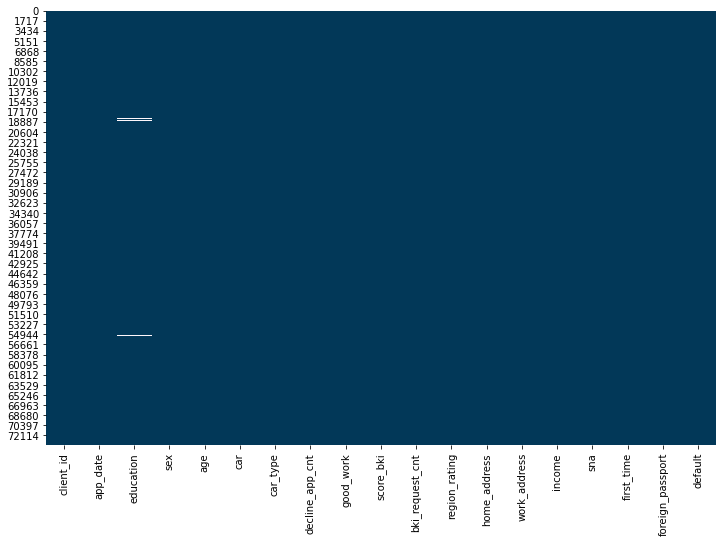

In [15]:
# Графическое отображение нахождения пропусков в обучающей базе
fig, ax = plt.subplots(figsize=(12, 8))
sns_heatmap = sns.heatmap(train.isna(),cbar=False, cmap ='PuBu_r')

In [16]:
# Количество пропусков в тестовой базе
test.isna().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

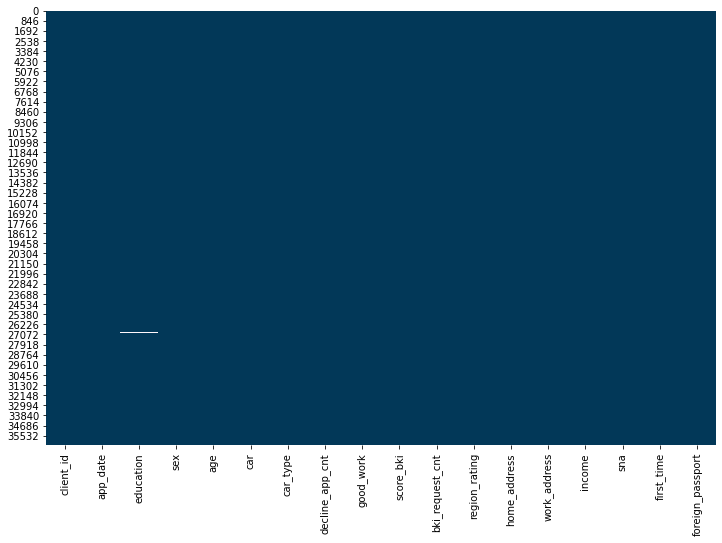

In [17]:
# Графическое отображение нахождения пропусков в тестовой базе
fig, ax = plt.subplots(figsize=(12, 8))
sns_heatmap = sns.heatmap(test.isna(),cbar=False, cmap ='PuBu_r')

<AxesSubplot:>

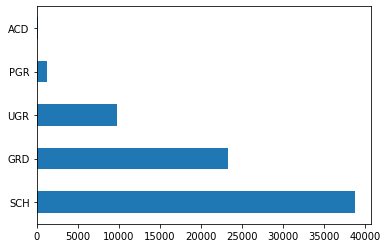

In [18]:
# Гистограмма значений признака education, содержащего пропуски, в обучающей базе
train.education.value_counts().plot.barh()

<AxesSubplot:>

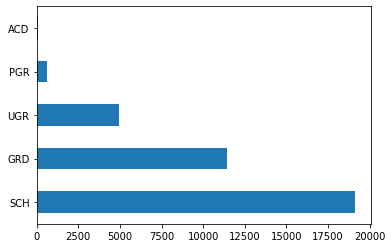

In [19]:
# Гистограмма значений признака education, содержащего пропуски, в тестовой базе
test.education.value_counts().plot.barh()

In [20]:
# Избавление от пропусков
train['education'].fillna('empty', inplace=True)
test['education'].fillna('empty', inplace=True)

In [21]:
# Выведем наименования всех признаков обучающей базы
train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

Разбиваем признаки на 3 списка (искл. client_id, app_date)

In [22]:
# числовые 
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']

# категориальные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time']

# бинарные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# Числовые признаки

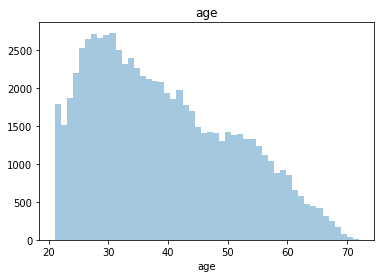

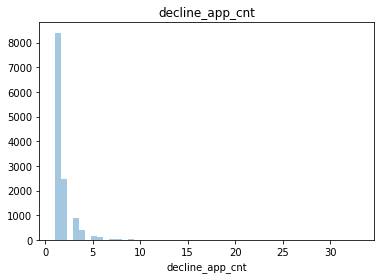

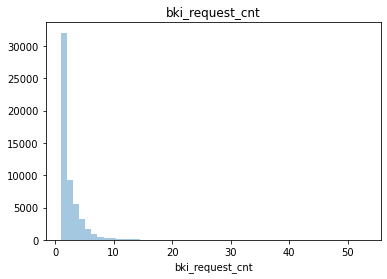

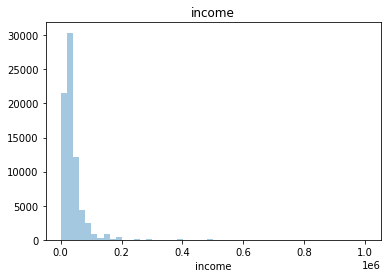

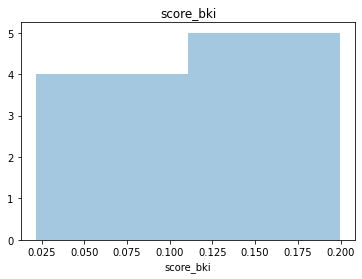

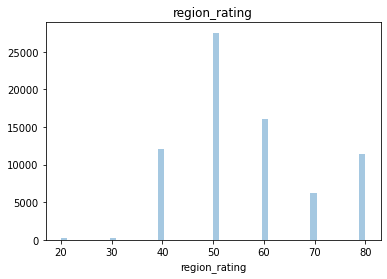

In [23]:
# Графики распределений числовых признаков
for i in num_cols:
    plt.figure()
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Прологарифмируем численные переменные, распределение которых смещено, но позже (в блоке Feature Engineering)

<AxesSubplot:>

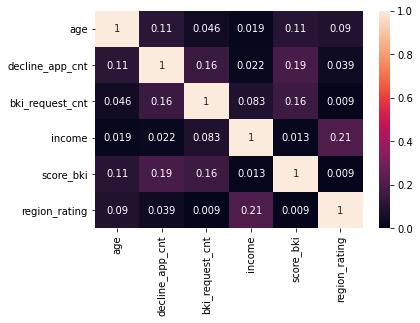

In [24]:
# Посмотрим на тепловую карту числовых признаков
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot = True)

Высокой корреляции не наблюдается

<AxesSubplot:>

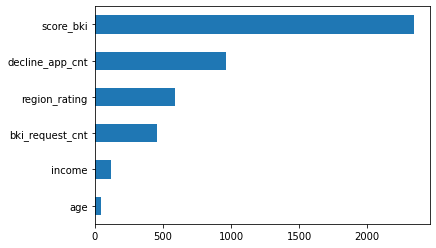

In [25]:
# Посмотрим значимость числовых признаков
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Бинарные и категориальные признаки

In [26]:
# Для бинарных признаков мы будем использовать LabelEncoder, чтобы избавится от строковых значений

label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
for column in bin_cols:
    test[column] = label_encoder.fit_transform(test[column])
    

In [27]:
# посмотрим как выглядит обучающая база после изменений
train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
35332,103964,22APR2014,GRD,1,43,0,0,0,0,-2.283283,3,60,1,1,45000,2,2,0,0
31815,69208,18MAR2014,GRD,1,30,0,0,0,1,-1.654474,3,60,1,1,25000,1,4,0,0
27572,13914,21JAN2014,SCH,0,43,1,1,0,0,-1.686836,3,70,1,3,45000,1,3,0,0
15747,93300,09APR2014,SCH,1,46,0,0,0,1,-2.218355,7,80,2,3,35000,2,3,0,0
22783,34853,11FEB2014,GRD,0,43,0,0,0,0,-1.780774,0,60,1,2,25000,4,2,0,0


In [28]:
# Заменим значения признака education числами в обучающей базе
education_dict = {'ACD': 4, 'PGR': 3, 'UGR': 2, 'GRD': 13, 'SCH': 0, 'empty': 0}
train.education = train['education'].map(education_dict)

train.education.value_counts()

0     39167
13    23365
2      9816
3      1257
4       194
Name: education, dtype: int64

In [29]:
# Заменим значения признака education числами в тестовой базе
test.education = test['education'].map(education_dict)

test.education.value_counts()

0     19309
13    11403
2      4932
3       608
4        97
Name: education, dtype: int64

In [30]:
# Переведем даты из признака app_date к типу datetime 
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)

In [31]:
# Посмотрим количество уникальных годов в признаке app_date обучающей базы
train.app_date.apply(lambda x: x.year).value_counts()

2014    73799
Name: app_date, dtype: int64

In [32]:
# Посмотрим количество уникальных годов в признаке app_date тестовой базы
test.app_date.apply(lambda x: x.year).value_counts()

2014    36349
Name: app_date, dtype: int64

In [33]:
# Посмотрим количество уникальных месяцев в признаке app_date обучающей базы
train.app_date.apply(lambda x: x.month).value_counts()

3    21178
2    18028
4    17683
1    16910
Name: app_date, dtype: int64

In [34]:
# Посмотрим количество уникальных месяцев в признаке app_date тестовой базы
test.app_date.apply(lambda x: x.month).value_counts()

3    10419
2     9069
4     8583
1     8278
Name: app_date, dtype: int64

# Добавление новых признаков (Feature engineering)

In [35]:
# Новый признак месяца подачи заявления на кредит
train['month'] = train.app_date.apply(lambda x: x.month)
test['month'] = train.app_date.apply(lambda x: x.month)

cat_cols.append('month')

In [36]:
# Новый признак количество дней между датой подачи заявления на кредит и датой первой подачи в базе
train['days'] = (train.app_date - train.app_date.min()).dt.days
test['days'] = (test.app_date - test.app_date.min()).dt.days

num_cols.append('days')

In [37]:
# посмотрим на ифнормацию по базам после изменений  
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         73799 non-null  int64         
 1   app_date          73799 non-null  datetime64[ns]
 2   education         73799 non-null  int64         
 3   sex               73799 non-null  int64         
 4   age               73799 non-null  int64         
 5   car               73799 non-null  int64         
 6   car_type          73799 non-null  int64         
 7   decline_app_cnt   73799 non-null  int64         
 8   good_work         73799 non-null  int64         
 9   score_bki         73799 non-null  float64       
 10  bki_request_cnt   73799 non-null  int64         
 11  region_rating     73799 non-null  int64         
 12  home_address      73799 non-null  int64         
 13  work_address      73799 non-null  int64         
 14  income            7379

In [38]:
# Еще пробую добавить новые признаки, которые должны будут улучшить результаты модели
train['bki_age_reg'] = (train['score_bki']/train['age'])*train['region_rating']
test['bki_age_reg'] = (test['score_bki']/test['age'])*test['region_rating']

train['mult_sna_ftime'] = train['sna'] * train['first_time']
test['mult_sna_ftime'] = test['sna'] * test['first_time']

train['edu_and_income'] = (train['education'] + 1) * train['income']
test['edu_and_income'] = (test['education'] + 1) * test['income']

train['success_client'] = (train['foreign_passport'] + 1) * (train['good_work'] + 1) * (train['car'] + 1)
test['success_client'] = (test['foreign_passport'] + 1) * (test['good_work'] + 1) * (test['car'] + 1)

train['very_success_client'] = train['foreign_passport'] * train['good_work'] * train['car']
test['very_success_client'] = test['foreign_passport'] * test['good_work'] * test['car']

train['fpassp_and_gwork'] = train['foreign_passport'] * train['good_work'] 
test['fpassp_and_gwork'] = test['foreign_passport'] * test['good_work']

train['fpassp_and_car'] = train['foreign_passport'] * train['car']
test['fpassp_and_car'] = test['foreign_passport'] * test['car']

train['gwork_and_car'] = train['good_work'] * train['car']
test['gwork_and_car'] = test['good_work'] * test['car']

In [39]:
# Добавляем новые признаки в соответствующие списки
num_cols.append('bki_age_reg')
num_cols.append('mult_sna_ftime')
num_cols.append('edu_and_income')
cat_cols.append('success_client')
bin_cols.append('very_success_client')
bin_cols.append('fpassp_and_gwork')
bin_cols.append('fpassp_and_car')
bin_cols.append('gwork_and_car')

In [40]:
#Посмотрим на распределение значений decline_app_cnt в обучающей выборке
train.decline_app_cnt.value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
15        1
19        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

In [41]:
# изменим значения признака decline_app_cnt, которые встречаются наиболее редко, единственным значением
train['decline_app_cnt'] = train['decline_app_cnt'].apply(lambda x: x if x < 4 else 4)
test['decline_app_cnt'] = test['decline_app_cnt'].apply(lambda x: x if x < 4 else 4)

In [42]:
# Изменяем принадлежность к списку признаку decline_app_cnt
num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')

In [43]:
# Теперь прологарифмируем численные переменные, распределение которых смещено 

num_cols_log = ['age', 'bki_request_cnt', 'income']

for i in num_cols_log:
    train[i] = np.log(train[i] + 1)
    
    
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)

# Визуализация и значимость признаков

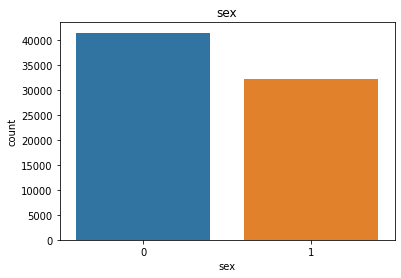

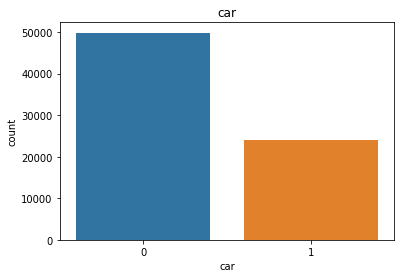

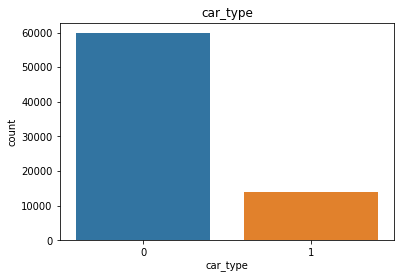

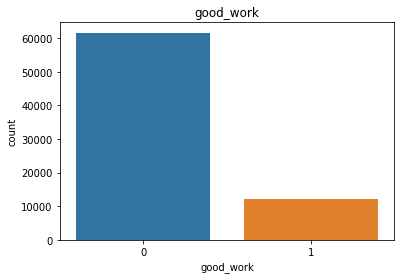

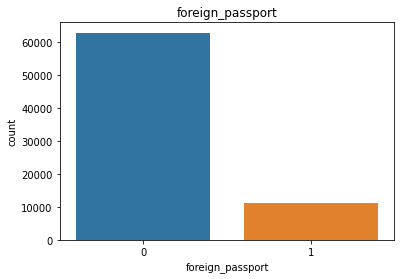

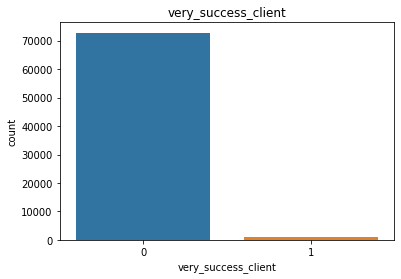

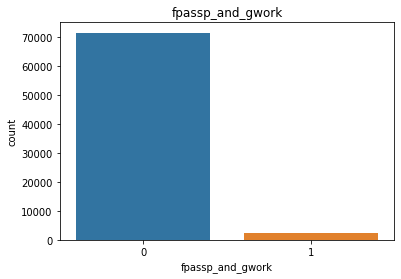

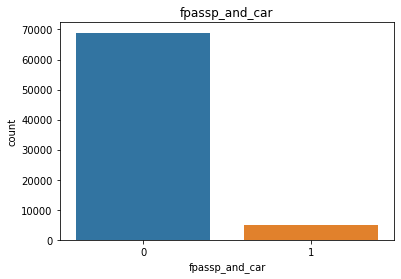

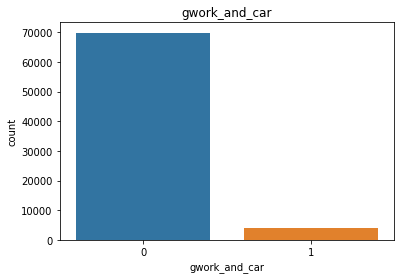

In [44]:
# Посмотрим на гистограммы распределения бинарных признаков
for column in bin_cols:
    plt.figure()
    sns.countplot(train[column])
    plt.title(column)
    plt.show()

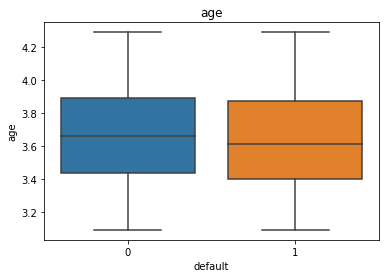

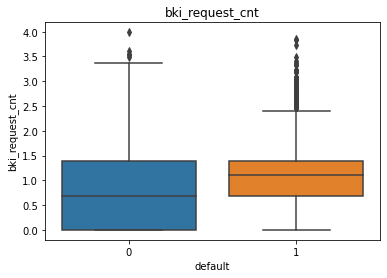

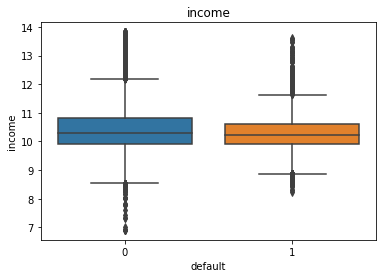

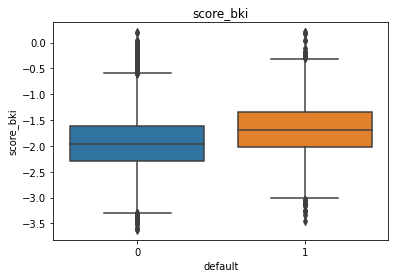

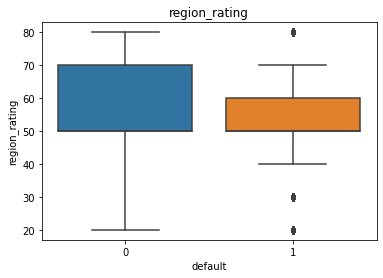

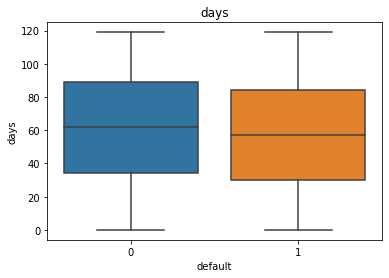

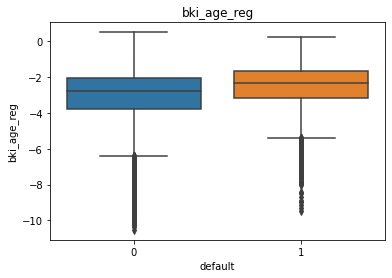

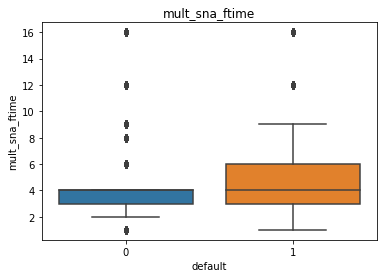

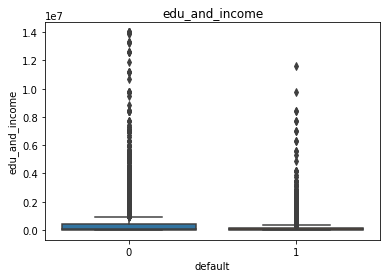

In [45]:
# boxplots числовых признаков
for column in num_cols:
    plt.figure()
    sns.boxplot(x=train['default'], y=train[column])
    plt.title(column)
    plt.show()

<AxesSubplot:>

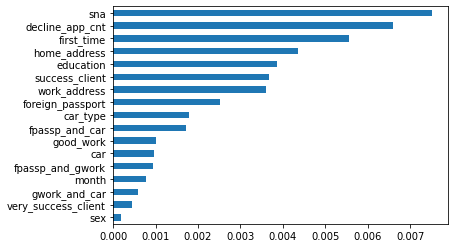

In [46]:
# Значимость бинарных и категориальных переменных
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Text(0.5, 0, 'F-value')

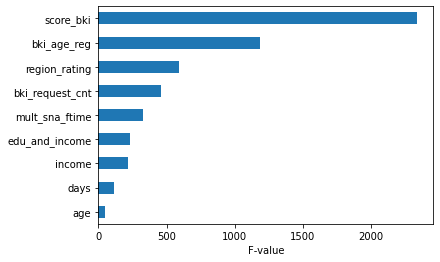

In [47]:
# еще раз посмотрим на значимость числовых переменных
imp_num = Series(f_classif(train[num_cols], train['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.xlabel('F-value')

In [48]:
# посмотрим на корреляцию признаков обучающей базы
corr_train = train.drop(['client_id', 'education'],axis = 1).corr()
corr_train.style.background_gradient(cmap='coolwarm').set_precision(3)

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,month,days,bki_age_reg,mult_sna_ftime,edu_and_income,success_client,very_success_client,fpassp_and_gwork,fpassp_and_car,gwork_and_car
sex,1.000,-0.127,0.279,0.226,0.023,-0.040,-0.045,-0.047,0.108,0.038,0.069,0.305,-0.004,0.014,0.086,0.020,-0.030,-0.033,-0.147,0.012,0.121,0.173,0.050,0.028,0.129,0.065
age,-0.127,1.000,-0.037,-0.034,-0.125,-0.073,-0.110,0.049,-0.091,0.000,-0.015,-0.093,-0.070,0.095,-0.037,-0.026,0.015,0.017,0.600,-0.036,-0.018,-0.069,-0.023,-0.045,-0.010,-0.049
car,0.279,-0.037,1.000,0.698,-0.036,0.002,-0.045,-0.046,0.065,-0.025,-0.008,0.325,-0.072,0.090,0.108,-0.043,-0.020,-0.022,-0.065,-0.003,0.197,0.599,0.172,0.050,0.385,0.344
car_type,0.226,-0.034,0.698,1.000,-0.048,0.018,-0.040,-0.016,0.104,-0.012,0.001,0.370,-0.086,0.104,0.146,-0.057,-0.025,-0.027,-0.084,-0.007,0.257,0.483,0.181,0.077,0.370,0.267
decline_app_cnt,0.023,-0.125,-0.036,-0.048,1.000,-0.030,0.203,0.123,-0.040,0.011,0.017,-0.013,0.069,-0.074,-0.030,0.121,-0.022,-0.023,0.061,0.027,-0.041,-0.051,-0.024,-0.025,-0.036,-0.025
good_work,-0.040,-0.073,0.002,0.018,-0.030,1.000,0.006,0.006,0.073,-0.004,-0.009,0.052,-0.054,0.056,0.046,-0.043,0.005,0.005,-0.081,-0.013,0.081,0.523,0.269,0.402,0.034,0.537
score_bki,-0.045,-0.110,-0.045,-0.040,0.203,0.006,1.000,0.140,0.009,0.014,0.013,0.003,0.068,-0.069,-0.022,0.175,-0.062,-0.064,0.499,0.040,-0.022,-0.036,-0.018,-0.013,-0.033,-0.014
bki_request_cnt,-0.047,0.049,-0.046,-0.016,0.123,0.006,0.140,1.000,-0.013,0.004,0.000,0.081,0.010,0.010,-0.003,0.079,-0.011,-0.010,0.112,0.026,0.052,-0.024,-0.010,-0.006,-0.014,-0.010
region_rating,0.108,-0.091,0.065,0.104,-0.040,0.073,0.009,-0.013,1.000,0.234,0.254,0.313,-0.078,0.089,0.255,-0.089,0.005,0.007,-0.548,-0.017,0.169,0.207,0.101,0.148,0.174,0.067
home_address,0.038,0.000,-0.025,-0.012,0.011,-0.004,0.014,0.004,0.234,1.000,0.728,0.047,0.115,-0.058,0.039,0.085,0.169,0.164,-0.117,0.062,0.029,0.011,0.019,0.028,0.022,-0.002


In [49]:
# Признаки с высокой корреляцией удалим (я оценил высокую как выше 0.8 по модулю)
cat_cols.remove('month')

# Подготовка модели

In [50]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
X_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
Y_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)
Y_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [52]:
# Стандартизация числовых непрерывных переменных на обучающей базе

X_num = StandardScaler().fit_transform(train[num_cols].values)
X_num

array([[ 1.71113664, -0.28100505, -0.78501579, ...,  0.98851239,
        -0.08042749, -0.45721178],
       [ 1.5399884 ,  0.77260728, -0.70752611, ...,  1.22122567,
        -0.08042749, -0.45547599],
       [-1.39343857, -0.28100505, -0.05288771, ..., -1.10104712,
        -0.08042749, -0.43638224],
       ...,
       [-0.66507223,  1.11179469,  0.5282444 , ..., -0.66484442,
        -0.08042749, -0.41034531],
       [-0.89146325,  0.77260728, -1.25140899, ...,  0.3147392 ,
         0.73304037, -0.46589076],
       [-0.35072683,  0.33531865, -0.31419734, ...,  0.28245698,
        -0.48716142,  0.11907224]])

In [53]:
# Стандартизация числовых непрерывных переменных на тестовой базе

Y_num = StandardScaler().fit_transform(test[num_cols].values)
Y_num

array([[-0.88333898,  0.76643419,  0.68282058, ..., -0.66617693,
        -0.07356829,  0.7835255 ],
       [ 0.12606863,  0.33072139, -2.63253397, ...,  0.77043507,
         3.20908805, -0.49782904],
       [ 0.97850869, -0.28338131, -0.05272498, ...,  0.94256865,
        -0.48390034, -0.34111661],
       ...,
       [-0.65688874, -0.28338131,  0.9453502 , ...,  1.06833449,
         1.56775988,  1.04164009],
       [-1.12541848,  0.33072139, -0.05272498, ..., -0.49568189,
        -1.30456442, -0.34111661],
       [ 0.0372345 ,  0.33072139, -1.05077617, ...,  0.73130861,
         1.56775988, -0.47939228]])

In [54]:
# Объединяем

X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

id_test = test['client_id']
test = np.hstack([Y_num, test[bin_cols].values, Y_cat])

In [55]:
# Разделяем обучающую выборку на тренировочную и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle = True)

In [56]:
# Подбор лучших гиперпараметров для модели

from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


In [57]:
# Описываем и обучаем модель
model = LogisticRegression( 
                           C=2.7825594022071245, 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l2', 
                           solver='liblinear', 
                           verbose=0, 
                           max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(C=2.7825594022071245, class_weight='balanced', max_iter=1000,
                   solver='liblinear')

In [58]:
# Предсказываем значения валидационной базы
Y_predict = model.predict(X_valid)
Y_predict_prob = model.predict_proba(X_valid)[:,1]

In [59]:
# Предсказываем значения тестовой базы
y_pred_test = model.predict(test)
y_pred_prob_test = model.predict_proba(test)[:,1]

# Предварительные результаты

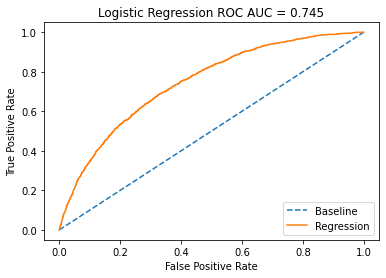

In [60]:
# Строим ROC-кривую
fpr, tpr, threshold = roc_curve(y_valid, Y_predict_prob)
roc_auc = roc_auc_score(y_valid, Y_predict_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

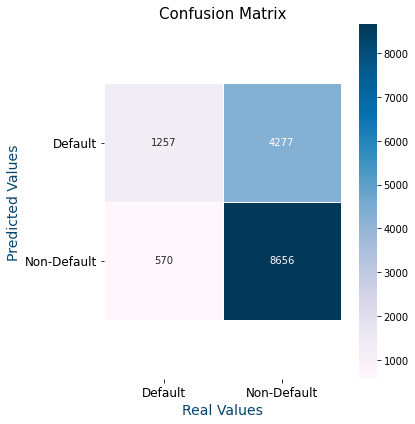

In [61]:
# Выведем confusion_matrix
show_confusion_matrix(y_valid, Y_predict)

In [62]:
# Выведем метрики качества модели
all_metrics(y_valid, Y_predict, Y_predict_prob)

,Value,Description
"Positive, P",1827.000000,default
"Negative, N",12933.000000,non-default
"True Positive, TP",1257.000000,correctly identified default
"True Negative, TN",8656.000000,correctly identified non-default
"False Positive, FP",4277.000000,incorrectly identified default
"False Negative, FN",570.000000,incorrectly identified non-default
Accuracy,0.671612,Accuracy=(TP+TN)/(P+N)
Precision,0.227141,Precision = TP/(TP+FP)
Recall,0.688013,Recall = TP/P
F1-score,0.341530,Harmonical mean of Precision и Recall


In [63]:
# Обучаем модель на всей обучающей базе
main_model = LogisticRegression( 
                           C=2.7825594022071245, 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l2', 
                           solver='liblinear', 
                           verbose=0, 
                           max_iter=1000)
main_model.fit(X, Y)

# Предсказываем значения тестовой базы
y_pred_test = main_model.predict(test)
y_pred_prob_test = main_model.predict_proba(test)[:,1]

# Submission

In [64]:
# Записываем предсказанные моделью вероятности дефолта заемщиков из тестовой базы в отдельный файл
new_sample_submission = pd.DataFrame({'client_id': id_test,
                              'default': y_pred_prob_test})
new_sample_submission.to_csv('submission.csv', index=False)

new_sample_submission.head(10)

,client_id,default
0,74835,0.199839
1,17527,0.807910
2,75683,0.287561
3,26883,0.410884
4,28862,0.140967
5,99881,0.603656
6,26630,0.811613
7,79934,0.157677
8,16605,0.142878
9,105449,0.130743
